In [1]:
import tensorflow as tf
import random
import numpy as np
import time
import sys, getopt
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
%matplotlib inline

def stdout(s):
    sys.stdout.write(str(s)+'\n')

In [10]:
nrod = 400
nlabel = 6
batchsize = 200
nHidden = 128
statenlayer = 1

features = ["x","y","th"]
# features = ["x","y","ft1","ft2"]
featdict = {}
for ft in features:
    featdict.update({ft:[]})

nchannel = len(features)

infile = "/scratch/walterms/mcmd/output/xmelt/processed/xmelt_test"
# infile = "/home/walterms/project/walterms/mcmd/nn/data/test/xjam"
maxNbl = -1 # use -1 for all

ckptdir = "/home/walterms/project/walterms/mcmd/nn/tfrnn/ckpts/"
ckptfile = ckptdir+"state/dropout_n0.1.ckpt"

In [3]:
###################
#  PREPARE INPUT  #
#       DATA      #
###################

# Count Nbl
Nbl = 0
fin = open(infile,'r')
for line in fin.readlines():
    if line == "\n":
        Nbl+=1
fin.close()

if maxNbl == -1 or Nbl < maxNbl:
    Nbl = Nbl - (Nbl%batchsize)
else:
    Nbl = maxNbl
    Nbl = Nbl - (Nbl%batchsize)
    
stdout("Effective Nbl in input: "+str(Nbl))

def gen_imgs(f,maxImg=-1):
    imgs = []
    stdout("Processing " + f + " for img set")
    thetas = []
    xs = []
    ys = []
    fin = open(f, 'r')
    nbl = 0
    for line in fin.readlines():
        if line.startswith("label"): continue
        if line == "\n":
            # Done a block
            # Insert data as triplets
            channels = [xs,ys,thetas]
            prep_data = []
            for ch in channels:
                prep_data.append(np.asarray(ch))
            formatted_data = np.stack(prep_data)
            np.random.shuffle(formatted_data)
            imgs.append(formatted_data)

            thetas = []
            xs = []
            ys = []
            nbl+=1
            if nbl == maxImg: 
                break
            continue
        spt = [float(x) for x in line.split()]
        xs.append(spt[0])
        ys.append(spt[1])
        thetas.append(spt[2])

    fin.close()
    return np.asarray(imgs)
    
    
# Prep imgs
stdout("Prepping imgs...")
input_imgs = gen_imgs(infile,Nbl)
stdout("Done")

Effective Nbl in input: 20000
Prepping imgs...
Processing /scratch/walterms/mcmd/output/xmelt/processed/xmelt_test for img set
Done


In [4]:
###################
#   STATE RNN     # 
###################
stdout("Creating State RNN Graph")
tf.reset_default_graph()

def variable_summaries(var):
    #A ttach a lot of summaries to a Tensor (for TensorBoard visualization)
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

# Define an lstm cell with tensorflow
def lstm_cell(nUnits):
    return rnn.BasicLSTMCell(nUnits)


X = tf.placeholder("float", [None, nchannel, nrod])
Y = tf.placeholder("float", [None, nlabel])

weights = {
    'h1': tf.Variable(tf.random_normal([nHidden, nHidden],stddev=0.1, dtype=tf.float32), name='W1'),
    'out': tf.Variable(tf.random_normal([nHidden, nlabel],stddev=0.1, dtype=tf.float32), name='W'),
    
}
biases = {
    'b1': tf.Variable(tf.random_normal([nHidden],stddev=0.1, dtype=tf.float32), name='b1'),
    'out': tf.Variable(tf.random_normal([nlabel],stddev=0.1, dtype=tf.float32), name='bias')
}


def RNN(x, weights, biases):
    # Build high lvl rnn for time series
    x = tf.unstack(x, nchannel, 1)
    #cell = lstm_cell(nHidden)
    stack = rnn.MultiRNNCell([lstm_cell(nHidden) for _ in range(statenlayer)])

    # Get lstm cell output
    outputs, states = rnn.static_rnn(stack, x, dtype=tf.float32)
    layer_trans = tf.add(tf.matmul(outputs[-1], weights['h1']), biases['b1'])
    layer_trans = tf.nn.sigmoid(layer_trans)
    # Linear activation, using rnn inner loop last output
    return tf.matmul(layer_trans, weights['out']) + biases['out']

logits = RNN(X,weights,biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))

eta = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(loss_op)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
stdout("Done")

Creating State RNN Graph
Done


In [11]:
###################
#   Feedforward   # 
###################
nbatches = Nbl//batchsize
saver = tf.train.Saver()

outpreds = np.zeros(shape=(nbatches*batchsize,nlabel))

stdout("Beginning Session")
with tf.Session() as sess:
    # Restore from checkpoint file
    stdout("Restoring from "+ckptfile)
    saver.restore(sess, ckptfile)
    stdout("Model restored")

    start = 0
    for ib in range(nbatches):
        # Pepare a batch
        end = start+batchsize
        xin = input_imgs[start:end]
        pred, = sess.run([prediction], feed_dict={X:xin})
#         outimgbatch = outimgbatch.transpose((0,2,1))
        
        for ip in range(batchsize):
            outpreds[start+ip] = pred[ip]
        
        start = end

    stdout("Done feeding infile")

Beginning Session
Restoring from /home/walterms/project/walterms/mcmd/nn/tfrnn/ckpts/state/dropout_n0.1.ckpt
INFO:tensorflow:Restoring parameters from /home/walterms/project/walterms/mcmd/nn/tfrnn/ckpts/state/dropout_n0.1.ckpt
Model restored
Done feeding infile


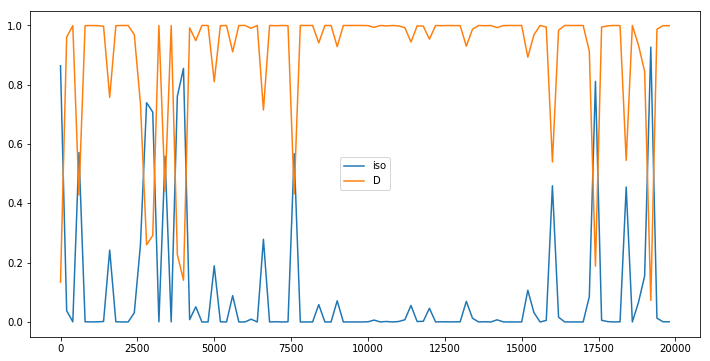

In [12]:
# Labels for reference
# [iso, D, T, X, U, L]
########################
npt = 100
skip = Nbl//npt

bl = [i for i in range(nbatches*batchsize)]
x = bl[::skip]
yiso = [p[0] for p in outpreds][::skip]
yd = [p[1] for p in outpreds][::skip]
yt = [p[2] for p in outpreds][::skip]
yx = [p[3] for p in outpreds][::skip]
yu = [p[4] for p in outpreds][::skip]
yl = [p[5] for p in outpreds][::skip]

f,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(x,yiso,label="iso")
ax.plot(x,yd,label="D")
# ax.plot(x,yt,label="T")
# ax.plot(x,yx,label="X")
# ax.plot(x,yu,label="U")
# ax.plot(x,yl,label="L")
ax.legend()

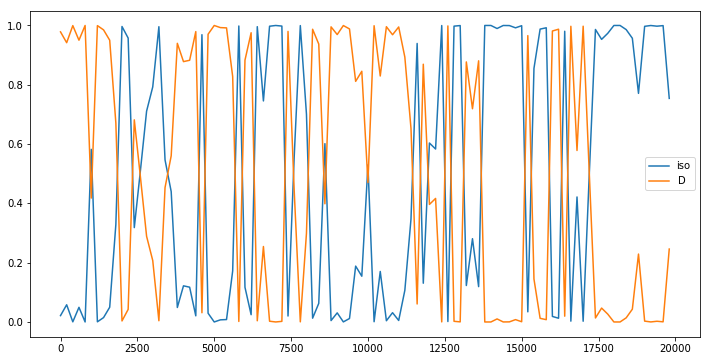

In [8]:
# Labels for reference
# [iso, D, T, X, U, L]
########################
npt = 100
skip = Nbl//npt

bl = [i for i in range(nbatches*batchsize)]
x = bl[::skip]
yiso = [p[0] for p in outpreds][::skip]
yd = [p[1] for p in outpreds][::skip]
yt = [p[2] for p in outpreds][::skip]
yx = [p[3] for p in outpreds][::skip]
yu = [p[4] for p in outpreds][::skip]
yl = [p[5] for p in outpreds][::skip]

f,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(x,yiso,label="iso")
ax.plot(x,yd,label="D")
# ax.plot(x,yt,label="T")
# ax.plot(x,yx,label="X")
# ax.plot(x,yu,label="U")
# ax.plot(x,yl,label="L")
ax.legend()